In [ ]:
from __future__ import print_function
import torchvision
from torchvision import datasets
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline
batch_size = 12

train_data = datasets.MNIST('D:\datasets',train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('D:\datasets',train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.in_dim = 28*28 #MNIST
        self.out_dim = 10
        
        self.fc1 = nn.Linear(self.in_dim, 512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,self.out_dim)
        
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax()
        
    def forward(self,x):
        z1 = self.fc1(x.view(-1, self.in_dim))
        a1 = self.relu(z1)
        z2 = self.fc2(a1)
        a2 = self.relu(z2)
        a3 = self.relu(self.fc3(a2))
        a4 = self.relu(self.fc4(a3))
        logit = self.fc5(a4)
        return logit,(z1,a1,z2,a2)

In [ ]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
#배열형태로 값을 저장하기 위해서 만들어주는 텐서입니다.
z1 = torch.Tensor([])
a1 = torch.Tensor([])
z2 = torch.Tensor([])
a2 = torch.Tensor([])
y = torch.Tensor([])

In [ ]:
for epoch in range(10): #loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        #get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs, toch = model(inputs)
        
        #모델의 성능이 최고가 되는 값에서의 z1,a1,z2,a2,y를 계산하였습니다.
        if (epoch == 9):
            z1 = torch.cat((toch[0],z1),0)
            a1 = torch.cat((toch[1],a1),0)
            z2 = torch.cat((toch[2],z2),0)
            a2 = torch.cat((toch[3],a2),0)
            y = torch.cat((labels,y),0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        if (i+1)%2000==0:    #print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                 (epoch+1, i+1, running_loss/2000))
            running_loss =0.0
            
print('Finished Training')

[1,  2000] loss: 2.064
[1,  4000] loss: 0.592
[2,  2000] loss: 0.300
[2,  4000] loss: 0.228
[3,  2000] loss: 0.159
[3,  4000] loss: 0.144
[4,  2000] loss: 0.105
[4,  4000] loss: 0.108
[5,  2000] loss: 0.077
[5,  4000] loss: 0.079
[6,  2000] loss: 0.057
[6,  4000] loss: 0.063
[7,  2000] loss: 0.044
[7,  4000] loss: 0.049
[8,  2000] loss: 0.037
[8,  4000] loss: 0.038
[9,  2000] loss: 0.025
[9,  4000] loss: 0.030
[10,  2000] loss: 0.020
[10,  4000] loss: 0.024
Finished Training


In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

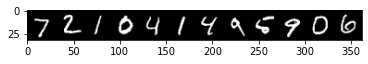

GroundTruth
   7   2   1   0   4   1   4   9   5   9   0   6
Prediction
   7   2   1   0   4   1   4   9   6   9   0   6


In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, nrow=batch_size))
print('GroundTruth')
print(" "+' '.join('%3s'%label.item() for label in labels))

outputs ,_ = model(images)
_, predicted = torch.max(outputs, 1)
print("Prediction")
print(" "+' '.join('%3s' % label.item() for label in predicted))

In [ ]:
n_predict = 0
n_correct = 0

for data in test_loader:
    inputs, labels = data
    outputs ,_ = model(inputs)
    _, predicted = torch.max(outputs, 1)
    
    n_predict += len(predicted)
    n_correct += (labels == predicted).sum()
    
print(f"{n_correct}/{n_predict}")
print(f"Accuracy: {n_correct/n_predict:.3f}")

9760/10000
Accuracy: 0.976


In [ ]:
#함수를 사용하여 값을 지정하는 방식을 사용하려고 하였지만 커널이 죽는 현상이 나타나 일일히 값을 지정하였습니다.
#처음에 값을 지정할 때 텐서형식으로 받아왔기때문에 다시 numpy 로 변환하는 과정을 해주었습니다. 
x = (z1.data.view(-1,z1.data.shape[1]) / 255.0).numpy()
y = y.numpy()
print(f'x.shape : {x.shape}')
print(f'y.shape : {y.shape}')

x.shape : (60000, 512)
y.shape : (60000,)


In [ ]:
feat_cols = [f'pixel{i}' for i in range(x.shape[1])]
df = pd.DataFrame(x, columns = feat_cols)
df['y'] = y

In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [ ]:
#2차원으로 축소하는 과정입니다. 
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.16094564 0.12548526]


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

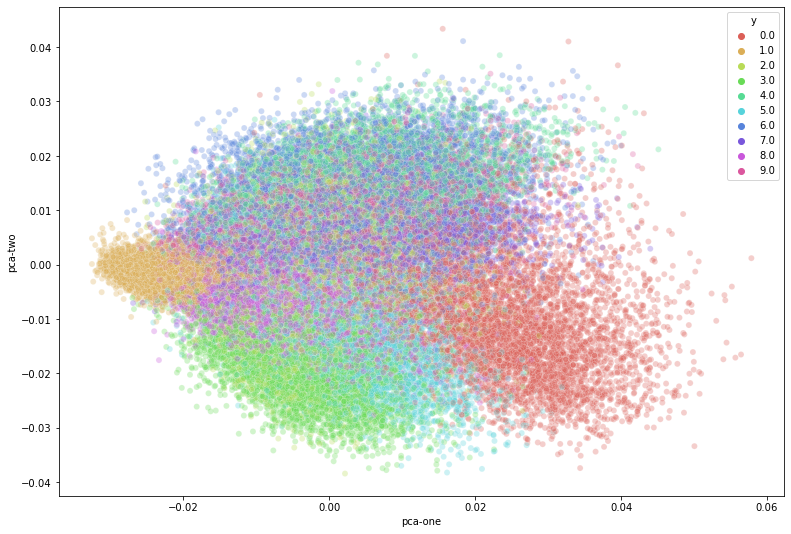

In [ ]:
plt.figure(figsize=(13,9))
sns.scatterplot(
        x="pca-one", y="pca-two",hue="y",
        palette=sns.color_palette("hls",10),
        data=df.loc[rndperm,:],
        legend="full", alpha=0.3
)

In [ ]:
N=10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one']=pca_result[:,0]
df_subset['pca-two']=pca_result[:,1]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.16391183 0.12448338]


In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
df_subset['tsne-2d-one']=tsne_results[:,0]
df_subset['tsne-2d-two']=tsne_results[:,1]
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/Users/seongjinhyeon/opt/anaconda3/envs/HYAI/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/seongjinhyeon/opt/anaconda3/envs/HYAI/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 4.576s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.008658


In [ ]:
plt.figure(figsize=(13,9))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",hue="y",
        palette=sns.color_palette("hls",10),
        data=df_subset,
        legend="full", alpha=0.3
        )
plt.show()